In [7]:
import os
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter
import os
import shutil

In [13]:
folder_path='../Image-Processing/Image-Processing/'

In [14]:
# count

In [15]:
file_count = 0

for root, dirs, files in os.walk(folder_path):
    file_count += len(files)  

print(f"Total files: {file_count}")

Total files: 4477


In [11]:
# merge car dataset

In [12]:
source_folder = '../Image-Processing/Image-Processing/Cars Dataset/'
destination_folder = '../Image-Processing/Image-Processing/Cars' 
os.makedirs(destination_folder, exist_ok=True)
for root, dirs, files in os.walk(source_folder):
    for file in files:
        source_file_path = os.path.join(root, file)
        destination_file_path = os.path.join(destination_folder, file)
        if os.path.exists(destination_file_path):
            base, ext = os.path.splitext(file)
            counter = 1
            while os.path.exists(destination_file_path):
                new_file_name = f"{base}_{counter}{ext}"
                destination_file_path = os.path.join(destination_folder, new_file_name)
                counter += 1
        
        shutil.copy2(source_file_path, destination_file_path)

print(f"All files have been merged into: {destination_folder}")


All files have been merged into: ../Image-Processing/Image-Processing/Cars


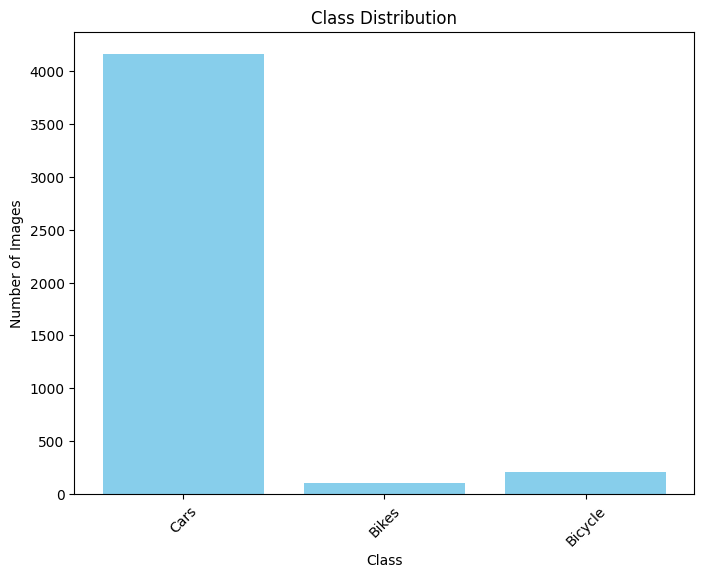

In [40]:
def plot_class_distribution(base_path, folders):
    class_counts = {}
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            class_counts[folder] = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
        else:
            class_counts[folder] = 0
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(base_path, folders)


In [11]:

base_path = "../Image-Processing/Image-Processing"
folders = ["Cars", "Bikes", "Bicycle"]
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")
test_dir = os.path.join(base_path, "test")

for directory in [train_dir, val_dir, test_dir]:
    for folder in folders:
        class_path = os.path.join(directory, folder)
        os.makedirs(class_path, exist_ok=True)
split_ratios = (0.7, 0.2, 0.1) 

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
   
        files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
        train_files, temp_files = train_test_split(files, test_size=(1 - split_ratios[0]), random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=(split_ratios[2] / (split_ratios[1] + split_ratios[2])), random_state=42)
        for file in train_files:
            shutil.copy(file, os.path.join(train_dir, folder))
        for file in val_files:
            shutil.copy(file, os.path.join(val_dir, folder))
        for file in test_files:
            shutil.copy(file, os.path.join(test_dir, folder))

print("Dataset restructured into train, val, and test directories.")


Dataset restructured into train, val, and test directories.


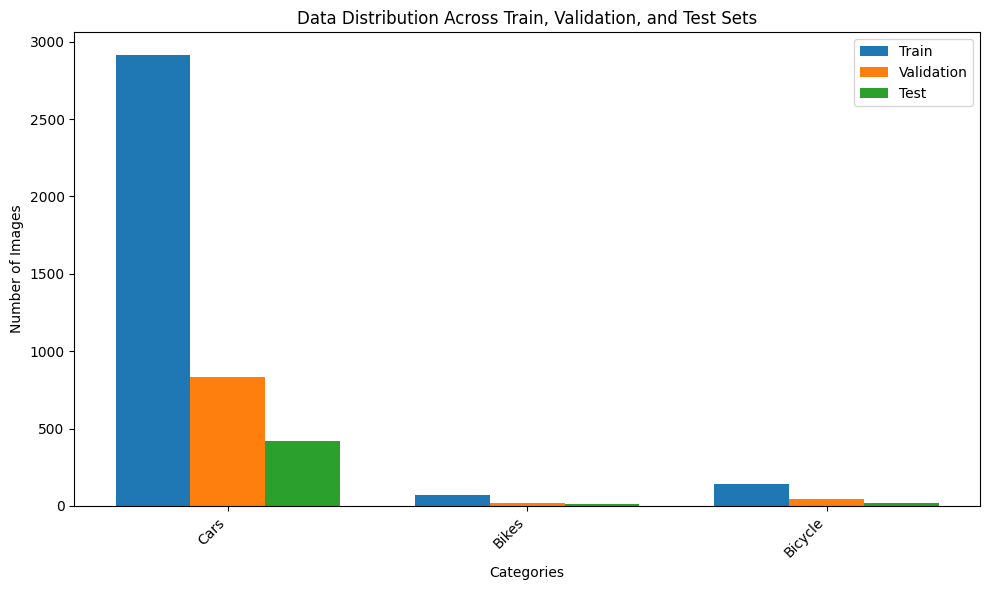

In [14]:
def count_files_in_directory(directory, class_names):
    counts = {}
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        counts[class_name] = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
    return counts

train_counts = count_files_in_directory(train_dir, folders)
val_counts = count_files_in_directory(val_dir, folders)
test_counts = count_files_in_directory(test_dir, folders)

categories = folders
train_values = [train_counts[folder] for folder in folders]
val_values = [val_counts[folder] for folder in folders]
test_values = [test_counts[folder] for folder in folders]

x = range(len(categories))
plt.figure(figsize=(10, 6))
plt.bar(x, train_values, width=0.25, label='Train', align='center')
plt.bar([p + 0.25 for p in x], val_values, width=0.25, label='Validation', align='center')
plt.bar([p + 0.50 for p in x], test_values, width=0.25, label='Test', align='center')

plt.xticks([p + 0.25 for p in x], categories, rotation=45, ha="right")
plt.title("Data Distribution Across Train, Validation, and Test Sets")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224) 
BATCH_SIZE = 32        
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0 
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
print("Class Indices:", train_generator.class_indices)


Found 3131 images belonging to 3 classes.
Found 896 images belonging to 3 classes.
Found 449 images belonging to 3 classes.
Class Indices: {'Bicycle': 0, 'Bikes': 1, 'Cars': 2}


# CLASSIFICATION
# CNN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from itertools import cycle
import tensorflow as tf
from tensorflow.keras import backend as K

2024-11-19 11:53:31.766612: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 11:53:31.797525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732017211.823011   16501 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732017211.828526   16501 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 11:53:31.866623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_roc_curve(model, test_generator, num_classes):
    """
    Plots the ROC curve for multi-class classification.
    """
   
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)

    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def load_data(base_dir, image_size, batch_size):
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

def plot_loss_curve(history):
    """
    Plots the training and validation loss curves.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def train_model(model, train_generator, val_generator, epochs,save_path=None):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr],
    )
    if save_path:
        model.save(save_path)
        print(f"Model saved to {save_path}")
    return history


def evaluate_model(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

def generate_classification_report(model, test_generator):
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    target_names = list(test_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=target_names, digits=4))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def compute_eer(label, pred, positive_label=1):
    fpr, tpr, thresholds = roc_curve(label, pred, pos_label=positive_label)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = (fpr[np.nanargmin(np.abs(fnr - fpr))] + fnr[np.nanargmin(np.abs(fnr - fpr))]) / 2
    return eer

def compute_eer(label, pred, positive_label=1):
    fpr, tpr, thresholds = roc_curve(label, pred, pos_label=positive_label)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = (fpr[np.nanargmin(np.abs(fnr - fpr))] + fnr[np.nanargmin(np.abs(fnr - fpr))]) / 2
    return eer

def compute_multiclass_eer(y_true, y_scores):
    """
    Compute Equal Error Rate (EER) for multi-class classification.
    """
    n_classes = y_scores.shape[1]
    eers = []
    for i in range(n_classes):
       
        binary_labels = (y_true == i).astype(int)
        class_scores = y_scores[:, i]
        eer = compute_eer(binary_labels, class_scores)
        eers.append(eer)
        print(f"EER for class {i}: {eer:.4f}")
    average_eer = np.mean(eers)
    print(f"Average Equal Error Rate (EER): {average_eer:.4f}")
    return eers, average_eer

def calculate_eer(model, test_generator):
    """
    Calculate the EER for multi-class classification.
    """
    y_pred = model.predict(test_generator)
    y_true = test_generator.classes

    eers, average_eer = compute_multiclass_eer(y_true, y_pred)
    return eers, average_eer



def main():
    base_dir = "../Image-Processing/Image-Processing"
    image_size = (224, 224)
    batch_size = 32
    epochs = 100
    input_shape = (image_size[0], image_size[1], 3)
    num_classes = 3  
    model_save_path = "cnn_model.h5"
    train_generator, val_generator, test_generator = load_data(base_dir, image_size, batch_size)
    model = build_cnn_model(input_shape, num_classes)
    history = train_model(model, train_generator, val_generator, epochs,save_path=model_save_path)
    evaluate_model(model, test_generator)

    generate_classification_report(model, test_generator)
    
    plot_loss_curve(history)

    plot_roc_curve(model, test_generator, num_classes)

    eers, average_eer = calculate_eer(model, test_generator)
    print(f"EERs per class: {eers}")
    print(f"Average EER: {average_eer}")



Found 3131 images belonging to 3 classes.
Found 896 images belonging to 3 classes.
Found 449 images belonging to 3 classes.
Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 248ms/step - accuracy: 0.4511 - loss: 1.5613 - val_accuracy: 0.0469 - val_loss: 5.7612 - learning_rate: 0.0010
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.7630 - loss: 0.6406 - val_accuracy: 0.0469 - val_loss: 3.6223 - learning_rate: 0.0010
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.8907 - loss: 0.3723 - val_accuracy: 0.1127 - val_loss: 2.7790 - learning_rate: 0.0010
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.9251 - loss: 0.2626 - val_accuracy: 0.9308 - val_loss: 0.2931 - learning_rate: 0.0010
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.9387 - loss: 0.2126 - val_accuracy: 0.9442 - val_loss: 0.1940 - learning_rate: 0.0010
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.9347 - loss: 0.2237 - val_accuracy: 0.

Model saved to cnn_model.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9709 - loss: 0.1252
Test Loss: 0.0488
Test Accuracy: 0.9889
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step

Classification Report:
              precision    recall  f1-score   support

     Bicycle     0.8400    1.0000    0.9130        21
       Bikes     1.0000    0.6364    0.7778        11
        Cars     0.9976    0.9976    0.9976       417

    accuracy                         0.9889       449
   macro avg     0.9459    0.8780    0.8961       449
weighted avg     0.9903    0.9889    0.9883       449



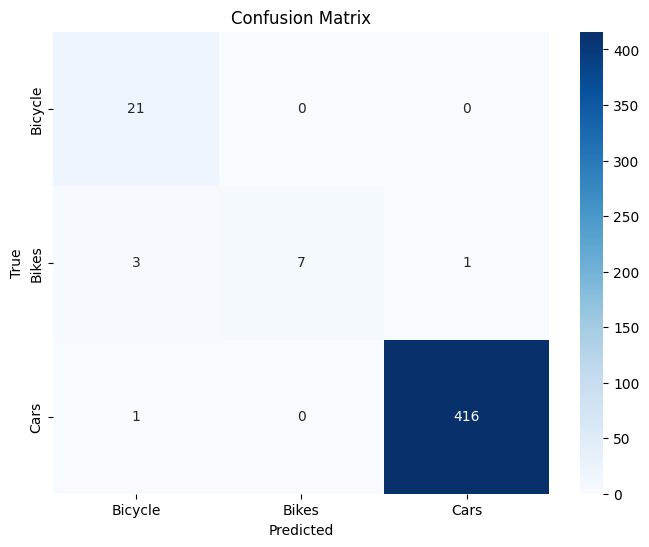

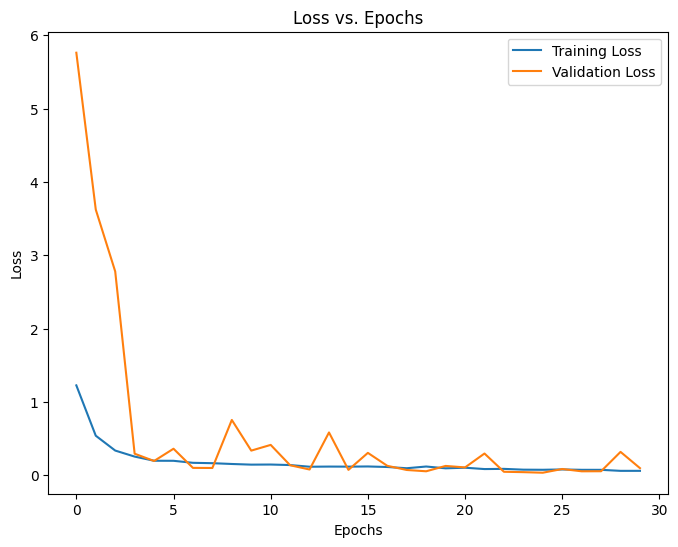

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


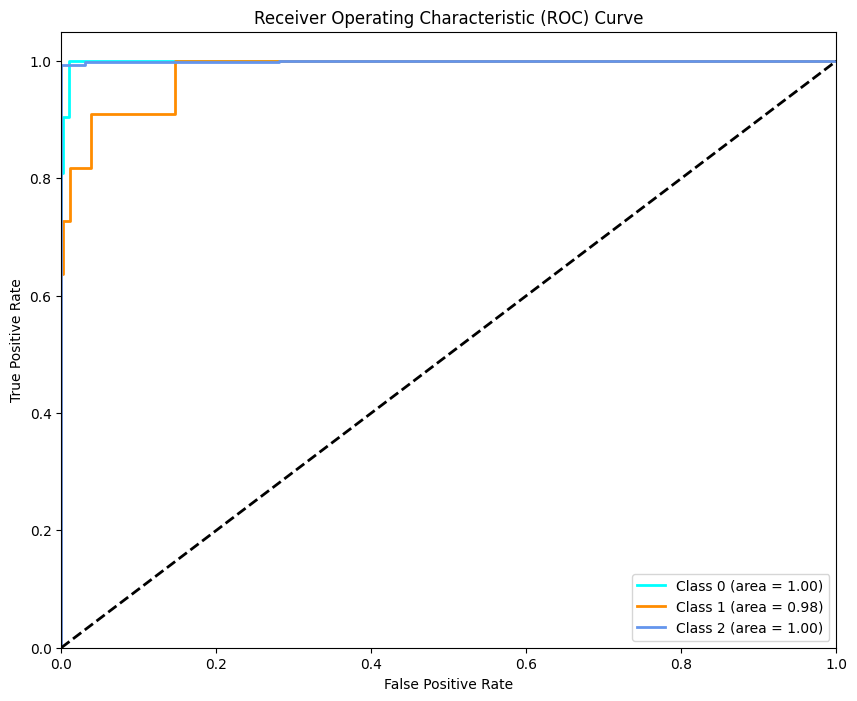

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
EER for class 0: 0.0047
EER for class 1: 0.1117
EER for class 2: 0.0036
Average Equal Error Rate (EER): 0.0400
EERs per class: [np.float64(0.004672897196261682), np.float64(0.11166459111664592), np.float64(0.003597122302158251)]
Average EER: 0.03997820353835529


In [24]:
if __name__ == "__main__":
    main()

# SEGMENTATION

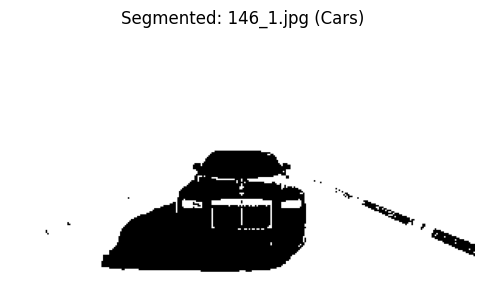

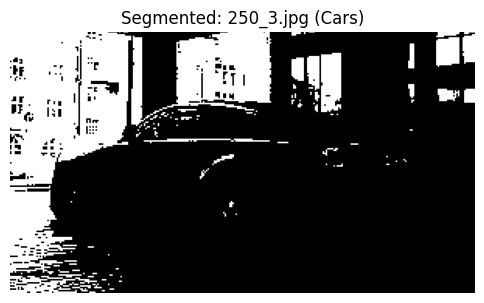

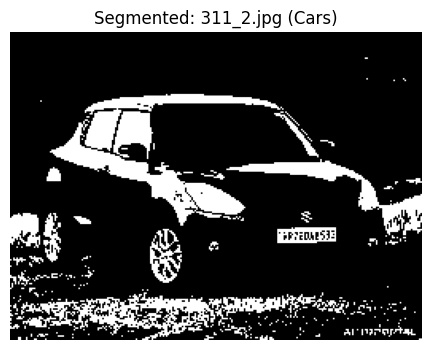

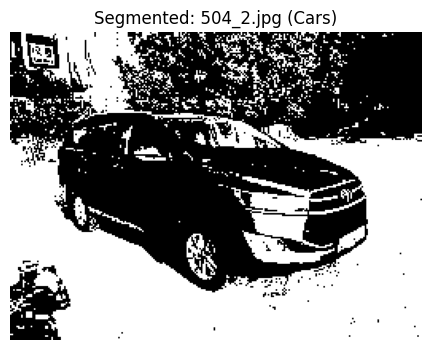

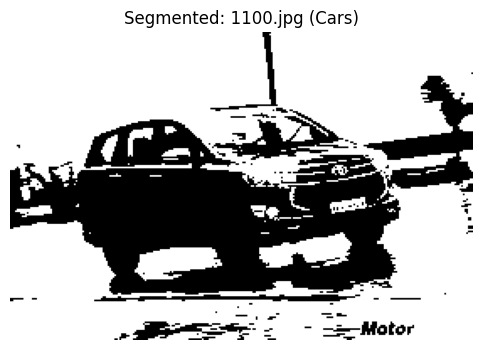

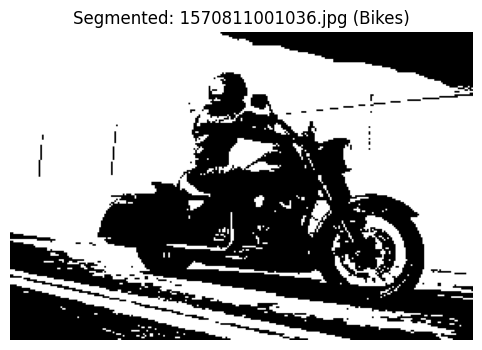

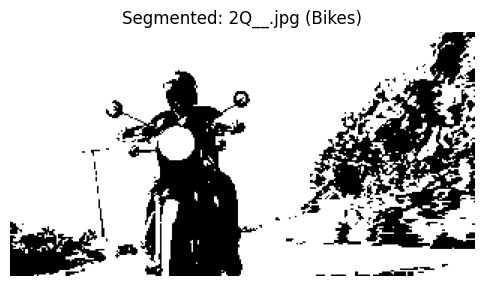

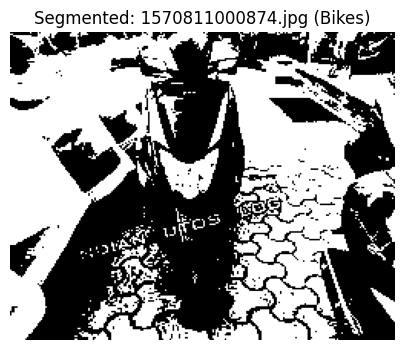

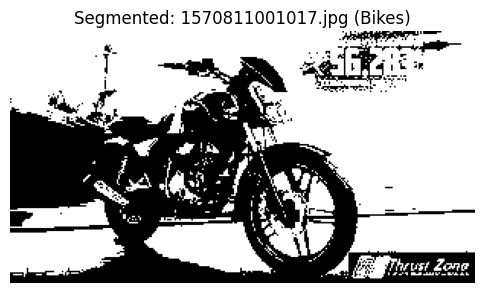

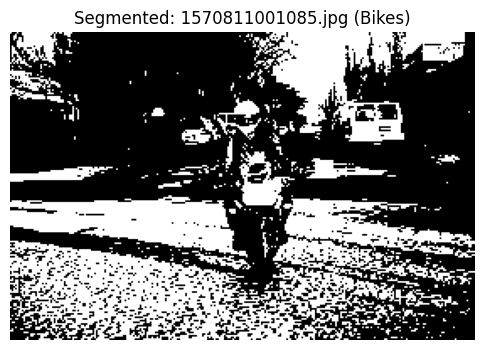

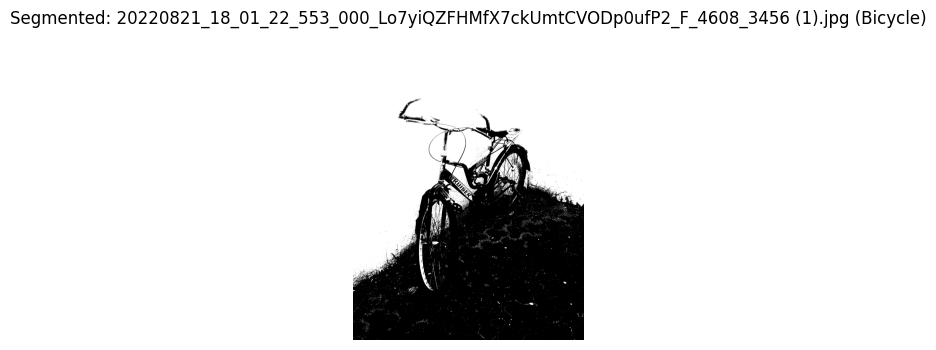

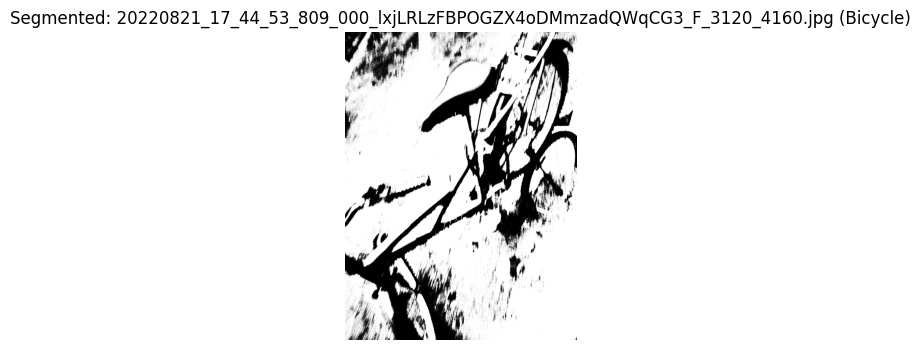

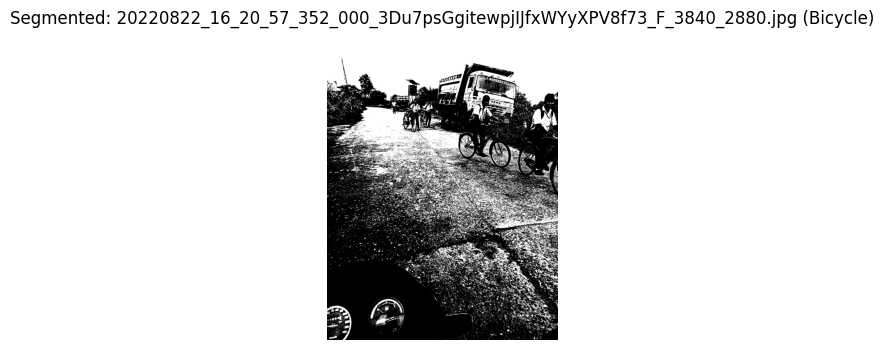

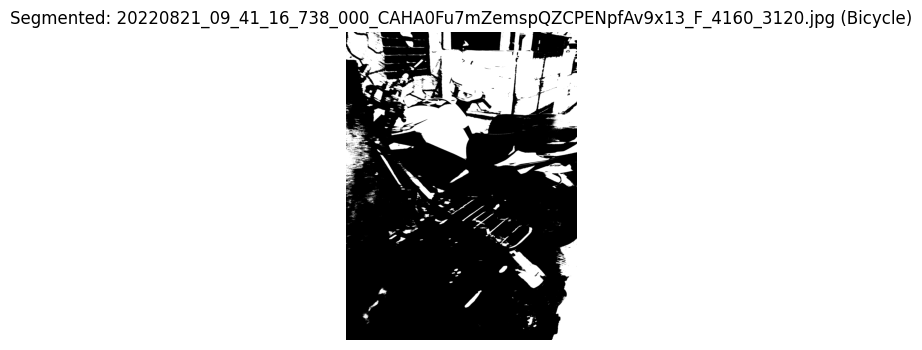

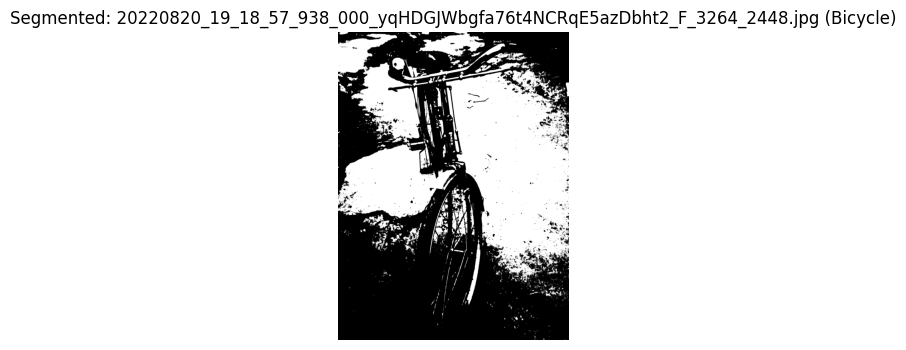

In [23]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

base_path = "../Image-Processing/Image-Processing"
folders = ["Cars", "Bikes", "Bicycle"]

def segment_image(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)
    return binary

images_per_class = 5

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        # Initialize counter for each class
        counter = 0
        for file in os.listdir(folder_path):
            if counter >= images_per_class:
                break  
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                segmented_image = segment_image(file_path)
                
                plt.figure(figsize=(6, 4))
                plt.title(f"Segmented: {file} ({folder})")
                plt.imshow(segmented_image, cmap='gray')
                plt.axis('off')
                plt.show()
                
                counter += 1 


# edge detection 

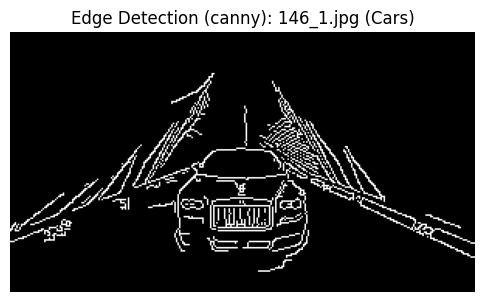

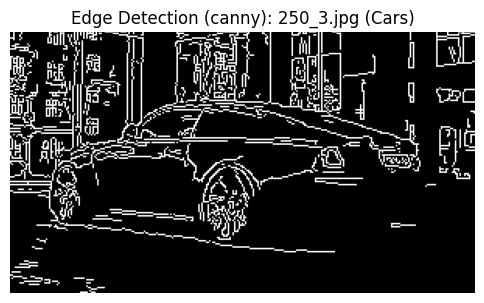

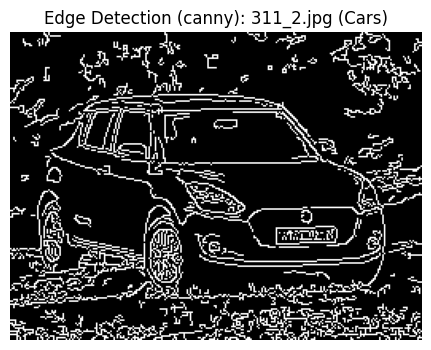

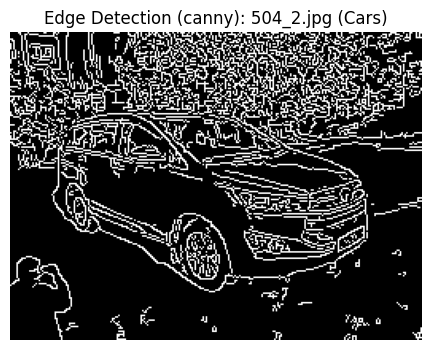

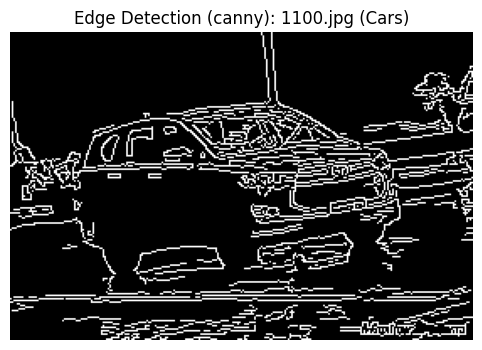

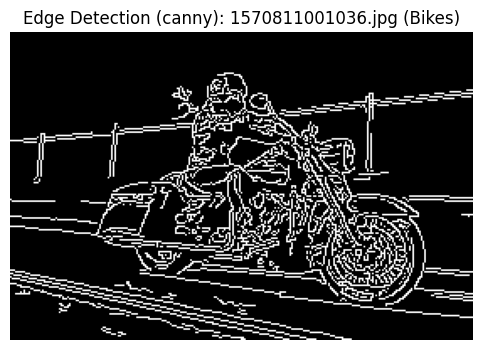

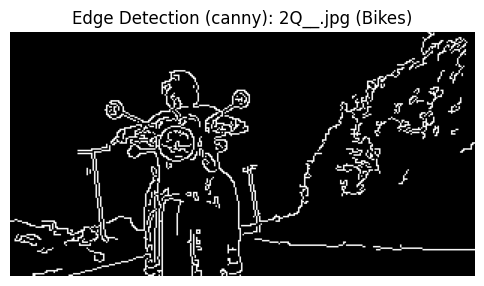

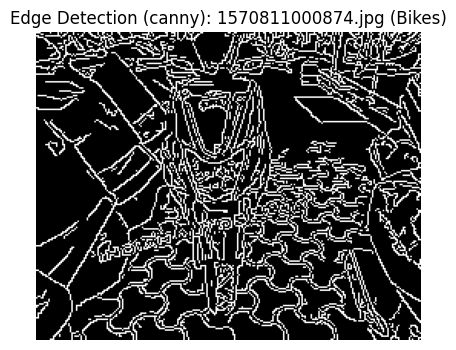

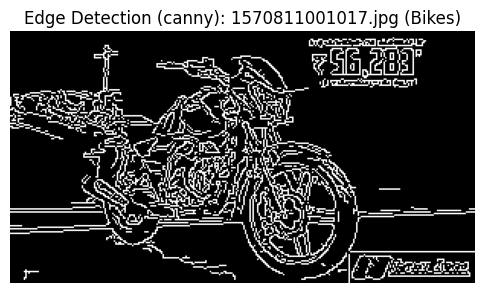

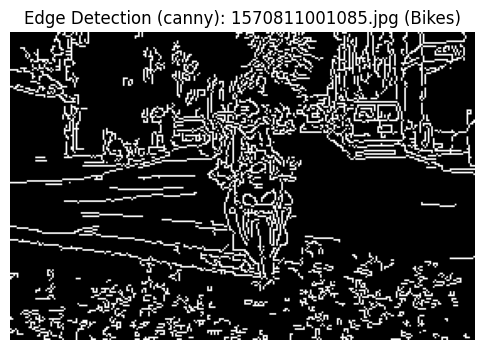

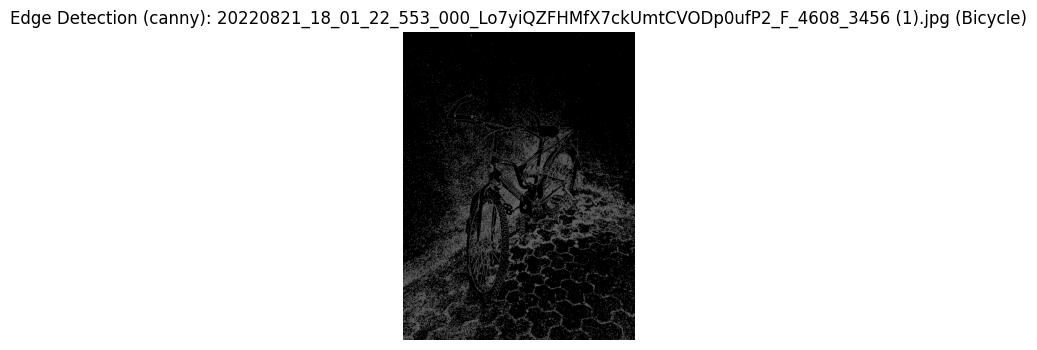

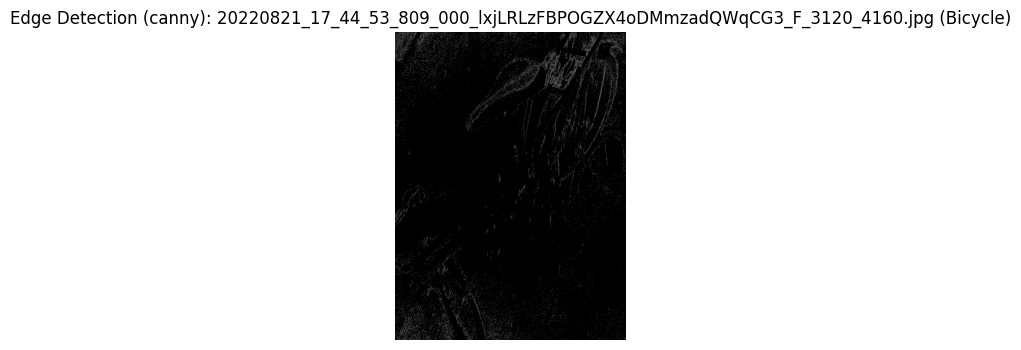

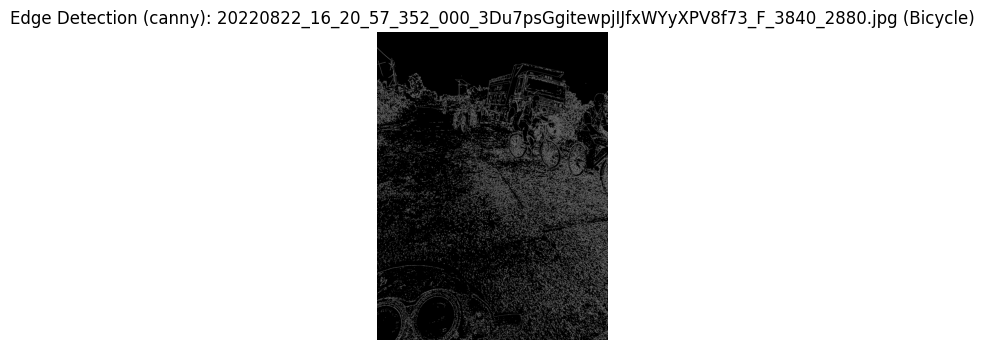

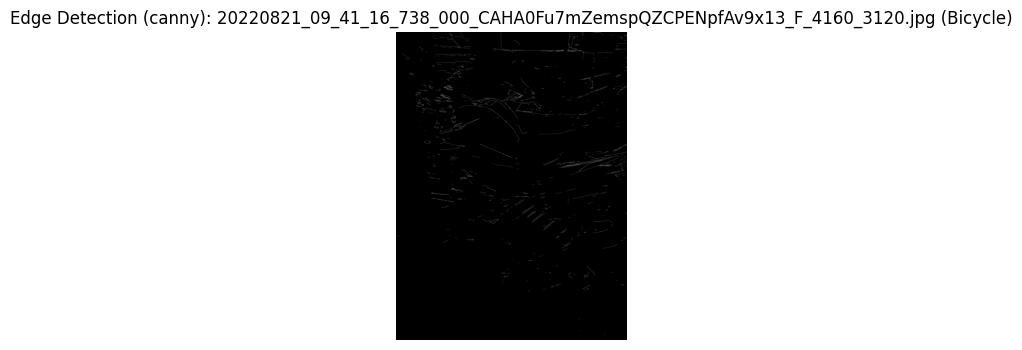

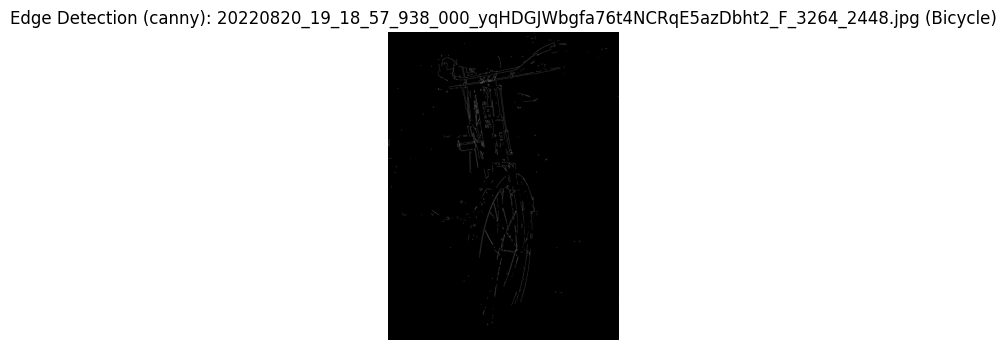

In [1]:
import cv2
import os
import matplotlib.pyplot as plt

base_path = "../Image-Processing/Image-Processing"
folders = ["Cars", "Bikes", "Bicycle"]

def edge_detection(image_path, method="canny"):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if method == "canny":
        edges = cv2.Canny(image, 100, 200)
    elif method == "sobel":
        edges_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        edges_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edges = cv2.magnitude(edges_x, edges_y)
    elif method == "laplacian":
        edges = cv2.Laplacian(image, cv2.CV_64F)
        edges = cv2.convertScaleAbs(edges)
    else:
        raise ValueError("Unknown method. Choose 'canny', 'sobel', or 'laplacian'.")
    return edges

images_per_class = 5
edge_method = "canny"

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        counter = 0
        for file in os.listdir(folder_path):
            if counter >= images_per_class:
                break
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                edges = edge_detection(file_path, method=edge_method)
                plt.figure(figsize=(6, 4))
                plt.title(f"Edge Detection ({edge_method}): {file} ({folder})")
                plt.imshow(edges, cmap='gray')
                plt.axis('off')
                plt.show()
                counter += 1


In [26]:
# 

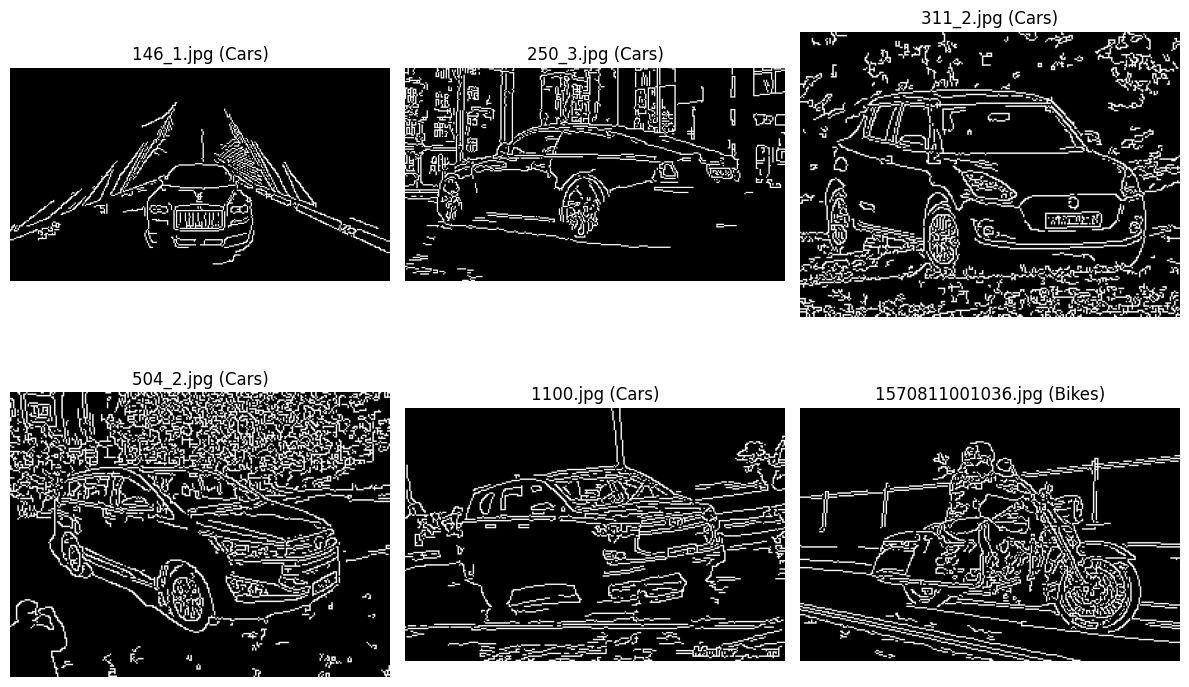

In [27]:
import matplotlib.pyplot as plt

def plot_image_grid(images, titles, grid_size=(2, 3)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 8))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

images = []
titles = []
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        counter = 0
        for file in os.listdir(folder_path):
            if counter >= images_per_class:
                break
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                edges = edge_detection(file_path, method=edge_method)
                images.append(edges)
                titles.append(f"{file} ({folder})")
                counter += 1
plot_image_grid(images, titles, grid_size=(2, 3))


# grey scale vs edge 

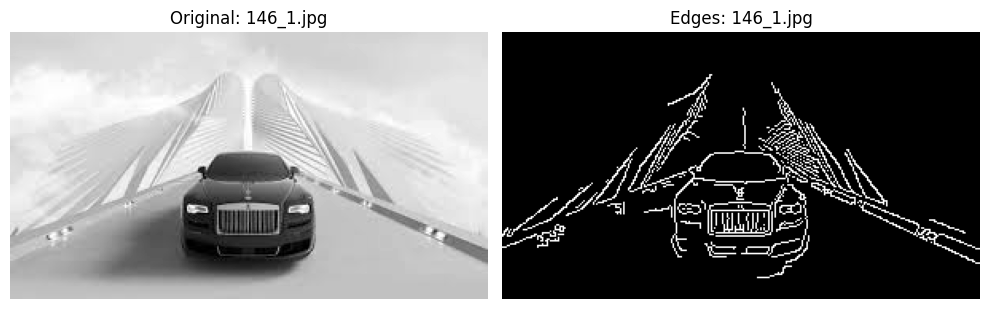

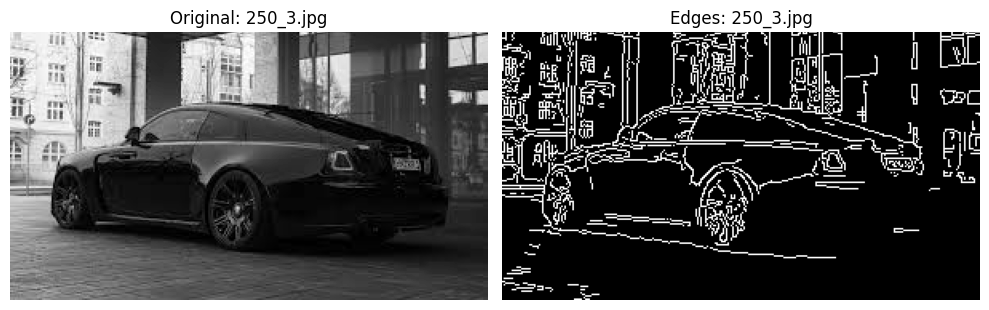

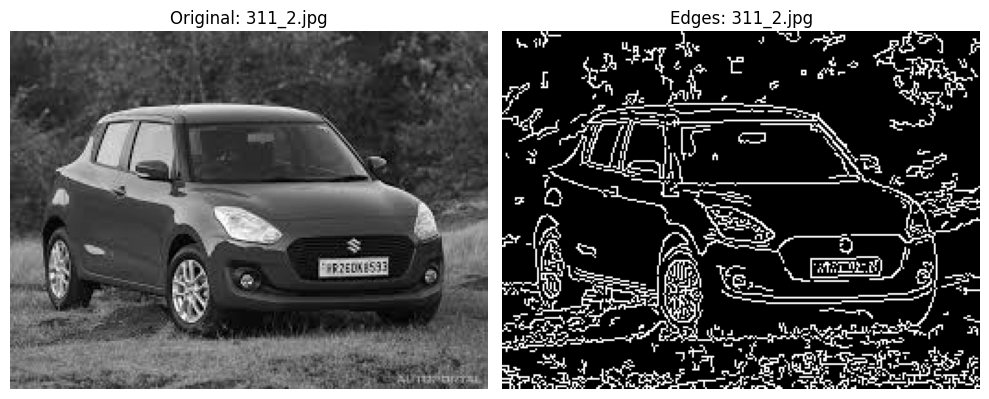

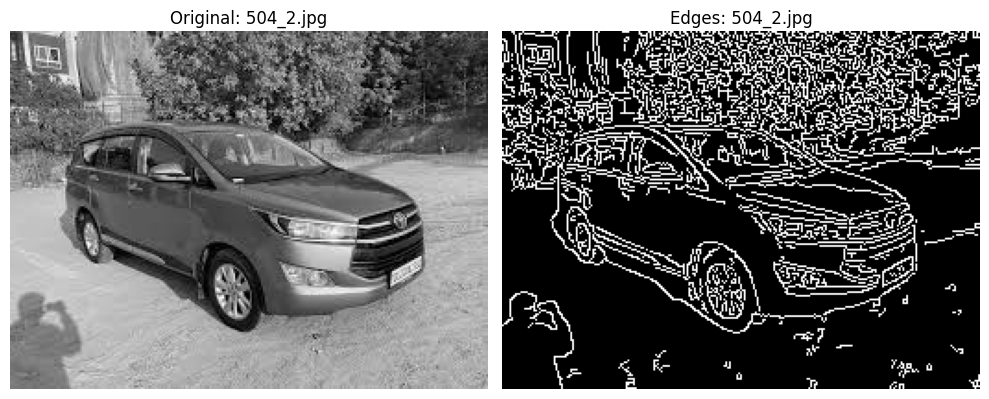

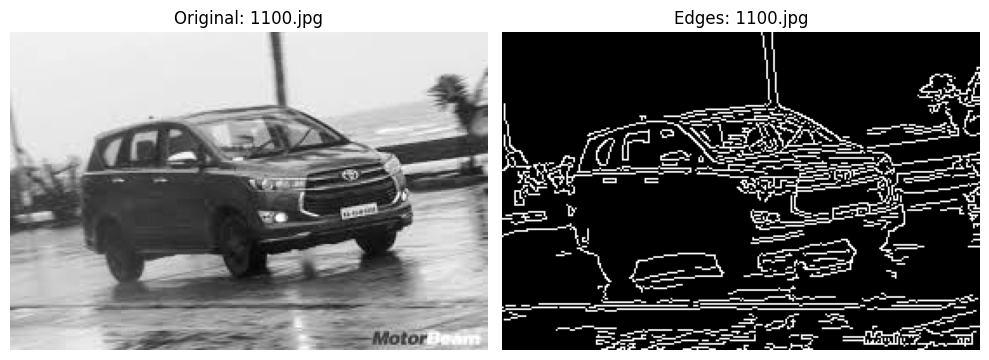

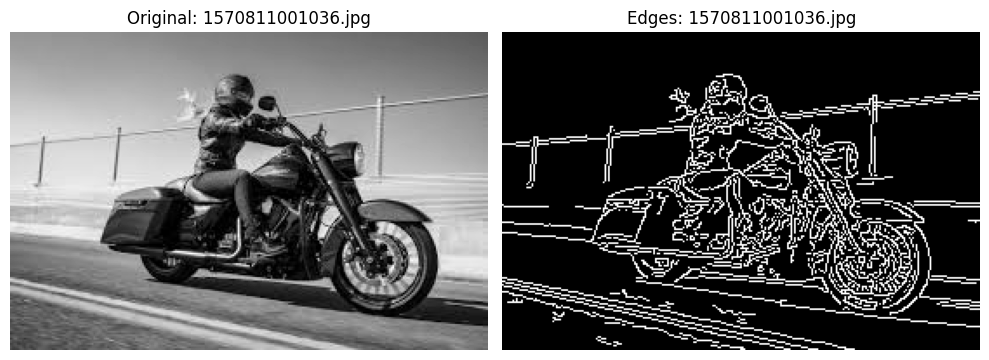

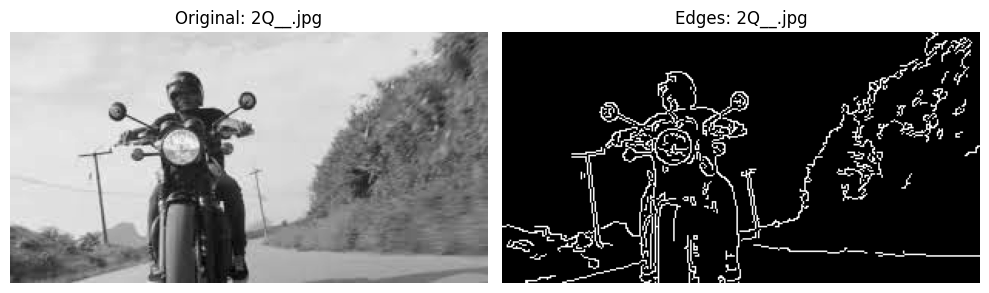

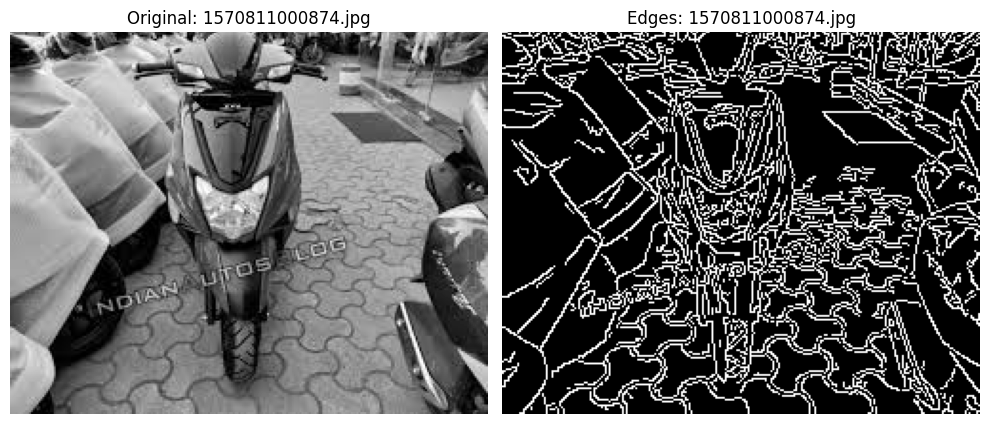

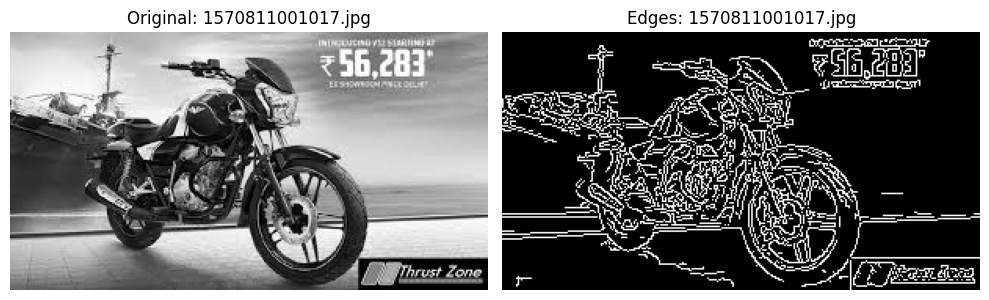

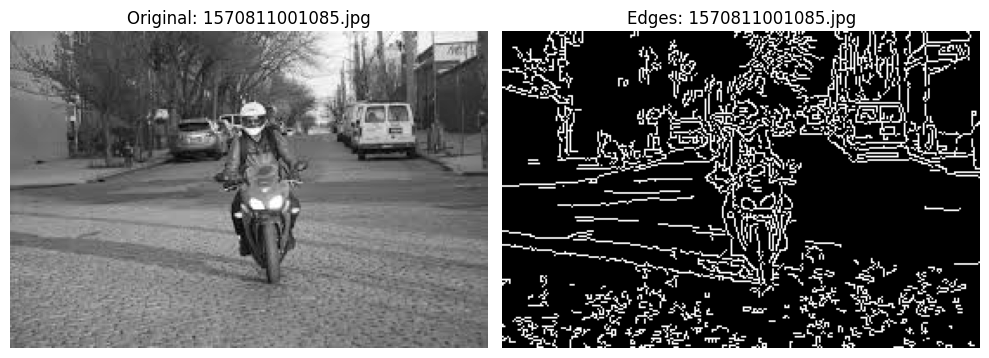

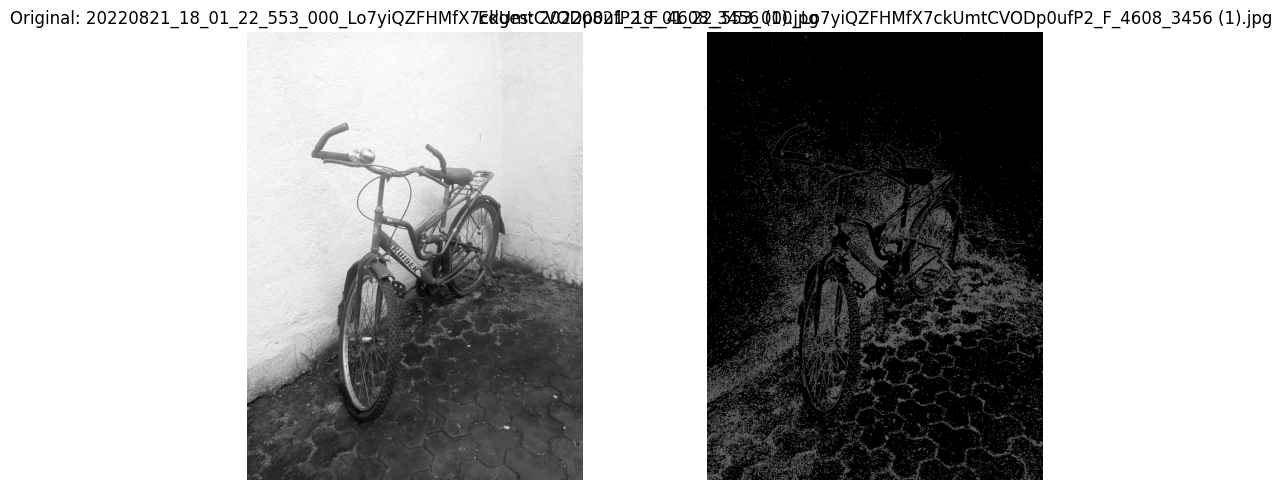

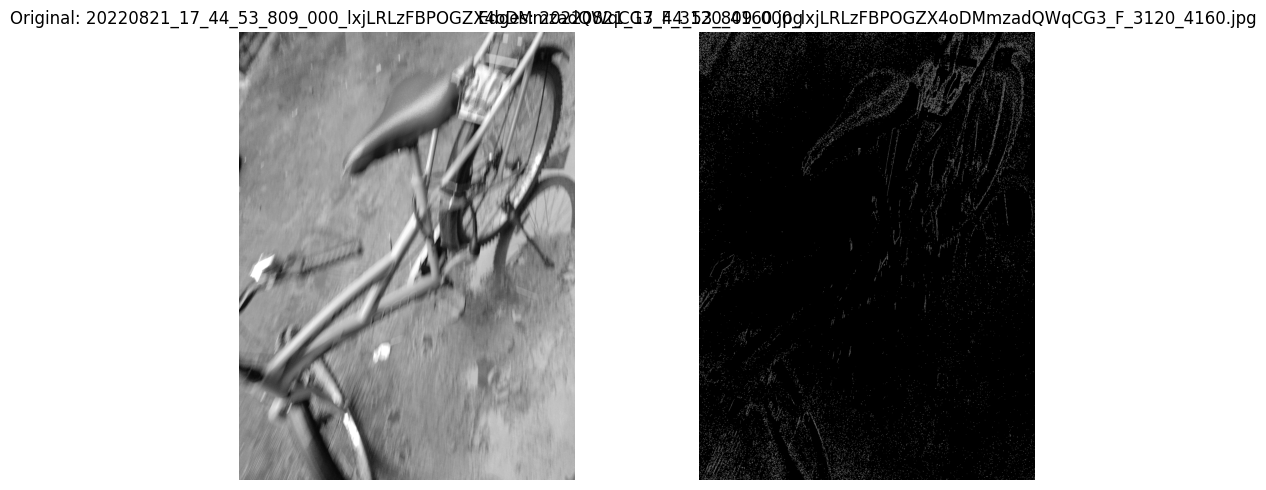

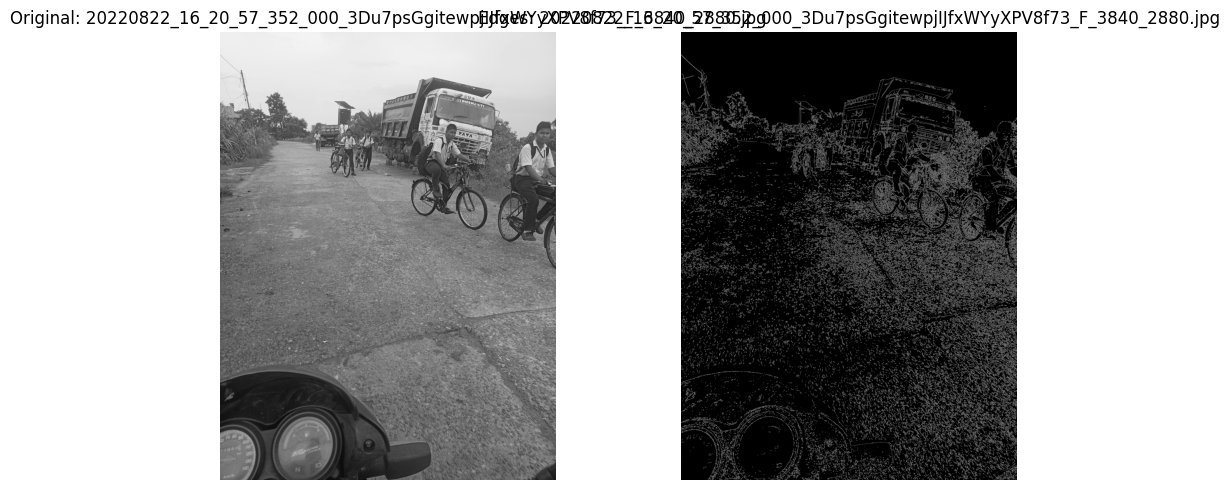

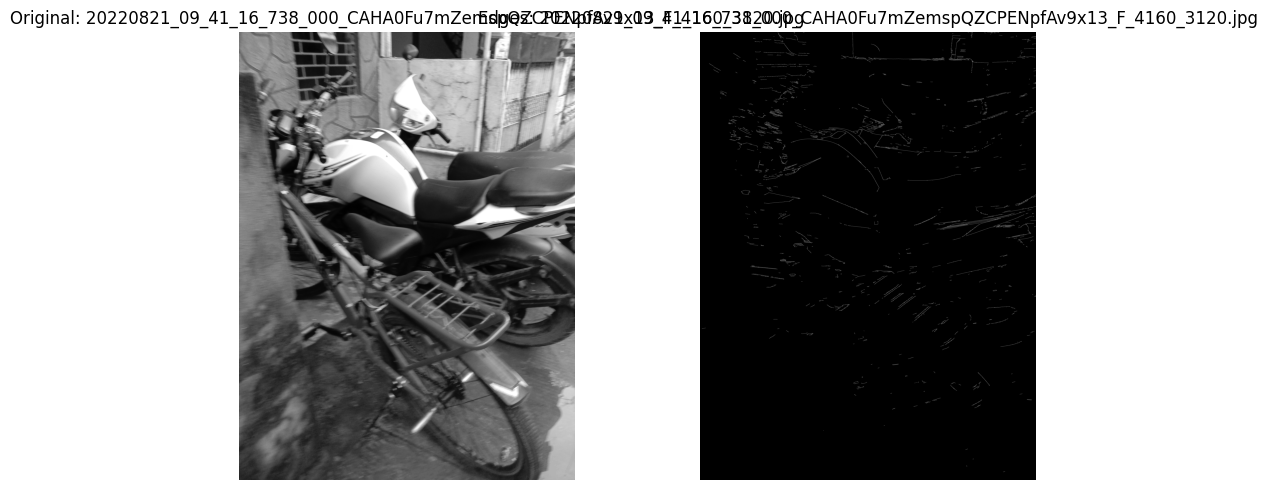

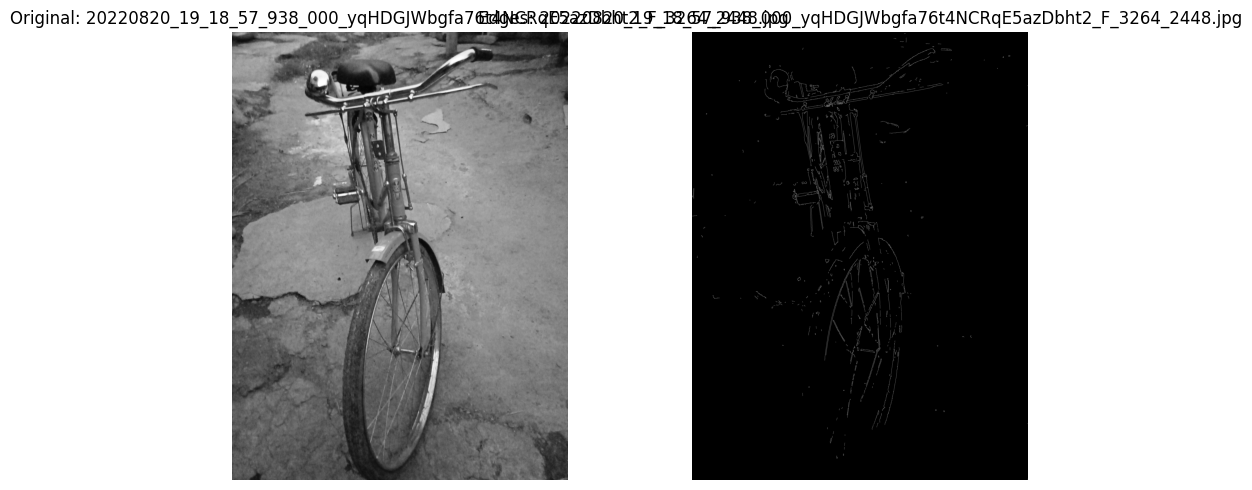

In [29]:
def plot_comparison(original, processed, titles):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(titles[0])
    axes[0].axis('off')
    axes[1].imshow(processed, cmap='gray')
    axes[1].set_title(titles[1])
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        counter = 0
        for file in os.listdir(folder_path):
            if counter >= images_per_class:
                break
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                original = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                edges = edge_detection(file_path, method=edge_method)
                plot_comparison(original, edges, titles=[f"Original: {file}", f"Edges: {file}"])
                counter += 1


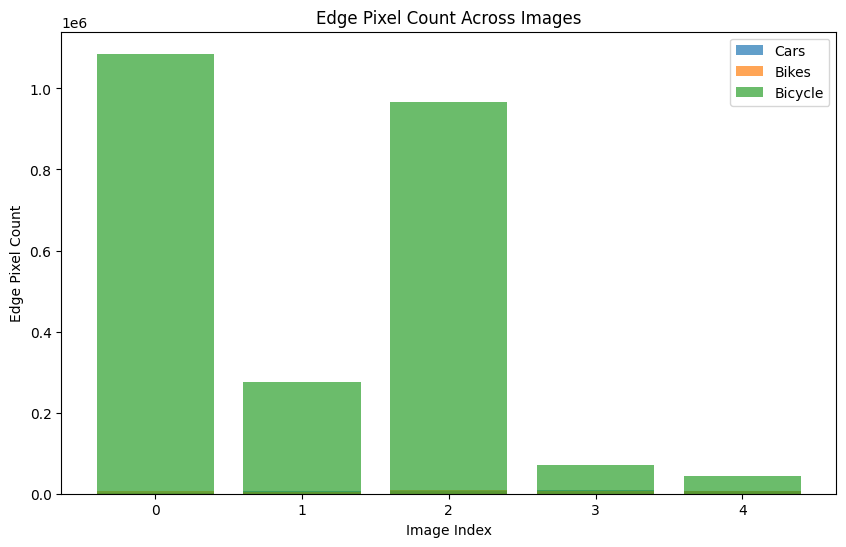

In [35]:
def edge_pixel_summary(base_path, folders, method="canny", images_per_class=5):
    edge_counts = {folder: [] for folder in folders}
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            counter = 0
            for file in os.listdir(folder_path):
                if counter >= images_per_class:
                    break
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path):
                    edges = edge_detection(file_path, method=method)
                    edge_counts[folder].append(np.sum(edges > 0))
                    counter += 1
    return edge_counts

edge_counts = edge_pixel_summary(base_path, folders, method=edge_method)

plt.figure(figsize=(10, 6))
for folder, counts in edge_counts.items():
    plt.bar(range(len(counts)), counts, label=folder, alpha=0.7)
plt.title("Edge Pixel Count Across Images")
plt.xlabel("Image Index")
plt.ylabel("Edge Pixel Count")
plt.legend()
plt.show()
